In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
import tensorflow.keras.utils
from tensorflow.keras.utils import multi_gpu_model
import pandas as pd

from datetime import datetime
from packaging import version

#print("TensorFlow version: ", tf.__version__)
#assert version.parse(tf.__version__).release[0] < 2, \
#    "This notebook does not worl for TensorFlow 2.0"

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import math
import time
import h5py
import sklearn
from sklearn.utils import shuffle
from tensorflow.keras import *

import os
# from numba import jit

# Preparing Data for CNN

In [2]:
dataset = '/mnt/data/ml/ShowJetsData_addgroomedtau.npz'
# dataset = '/mnt/data/ml/Constituent4vec_neve210k.npz'
data = np.load(dataset)
print(data.files)

['jetImages', 'jetPt', 'jetEta', 'jetPhi', 'tau21', 'tau31', 'tau32', 'chMult', 'neutMult', 'phoMult', 'eleMult', 'muMult', 'jetpull', 'labels']


In [3]:
images=np.array(data['jetImages'], dtype=np.float64).reshape(len(data['jetImages']),16,16,1)
eta=np.array(data['jetEta'], dtype=np.float64)
pt=np.array(data['jetPt'], dtype=np.float64)
phi=np.array(data['jetPhi'], dtype=np.float16)
tau21=np.array(data['tau21'], dtype=np.float64)
jetpull=np.array(np.abs(data['jetpull']/math.pi), dtype=np.float64)
labels=np.array(data['labels'], dtype=np.int16)
n_ch=np.array(data['chMult'], dtype=np.int16)
n_nh=np.array(data['neutMult'], dtype=np.int16)
n_gamma=np.array(data['phoMult'], dtype=np.int16)
n_e=np.array(data['eleMult'], dtype=np.int16)
n_mu=np.array(data['muMult'], dtype=np.int16)
# eta=np.array(data['jetconstEta'], dtype=np.float64)
# pt=np.array(data['jetconstPt'], dtype=np.float64)
# phi=np.array(data['jetconstPhi'], dtype=np.float16)
# evnum=np.array(data['jetconstEvnum'], dtype=np.float64)

In [4]:
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'figure.facecolor':'white'}
plt.rcParams.update(params)
plt.style.context('default')

### To make sure siganl and bkg are equal in number for 

In [5]:
numZ = np.min([np.sum(labels[:,1]==1)])
numData = np.min([numZ, np.sum(labels[:,0]==1)])

In [6]:
f = np.array(list(zip(images, pt, eta, phi, tau21, jetpull, n_ch, n_nh, n_gamma, n_e, n_mu, labels)))
df = pd.DataFrame(data=f, columns=['image', 'pT', 'eta', 'phi', 'tau21', 'jetpull', 'n_ch', 'n_nh', 'n_gamma', 'n_e',
                                       'n_mu', 'labels'])

In [7]:
# df.dtypes

In [8]:
z1= (labels[:,1]==1)
z1[np.argwhere(z1==True)[int(numData):]] = False

qcd= (labels[:,0]==1)
qcd[np.argwhere(qcd==True)[int(numData):]] = False

In [9]:
signal = shuffle(df[pd.Series(z1)]).reset_index(drop=True)
sig_labels = np.array(np.zeros((len(signal.index), 2)), dtype=np.int32)
sig_labels[:,0]=1
sig_labels = pd.Series(sig_labels.tolist())
signal = signal.drop(columns=['labels'])
signal['labels'] = sig_labels

In [10]:
# signal.corr()

In [11]:
# Signal image

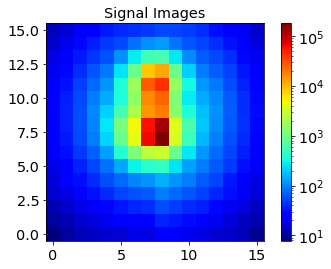

In [12]:
sig_images=np.sum(signal['image'],axis=0)
display_sig = sig_images.reshape(16,16)
plt.grid(False)
plt.imshow(display_sig, interpolation='nearest', origin='low', cmap = 'jet', norm=LogNorm())
plt.colorbar()
plt.title('Signal Images')
plt.show()

In [13]:
bkg = df[pd.Series(qcd)].reset_index(drop=True)
bkg_labels = np.array(np.zeros((len(bkg.index), 2)), dtype=np.int32)
bkg_labels[:,1]=1
bkg_labels = pd.Series(bkg_labels.tolist())
bkg = bkg.drop(columns=['labels'])
bkg['labels'] = bkg_labels

In [14]:
# bkg.corr()

### Background Image -- looks like this because we are selecting jets with atleast 2 subjets

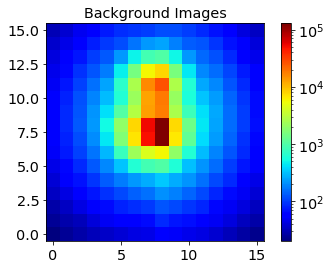

In [15]:
bkg_images=np.sum(bkg['image'],axis=0)
display_bkg = bkg_images.reshape(16,16)
plt.grid(False)
plt.imshow(display_bkg, interpolation='nearest', origin='low', cmap = 'jet', norm=LogNorm())
plt.colorbar()
plt.title('Background Images')
plt.show()

In [16]:
# Displaying some features

In [17]:
signame = r'$ZZ$'
bkgname = 'QCD'

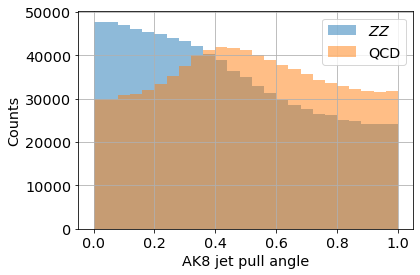

In [30]:
signal['jetpull'].hist(bins=25, alpha=0.5, label = signame )
bkg['jetpull'].hist(bins=25, alpha=0.5, label = bkgname)
plt.xlabel('AK8 jet pull angle')
plt.ylabel("Counts")
plt.legend()
plt.savefig('plots/pullangle.png')

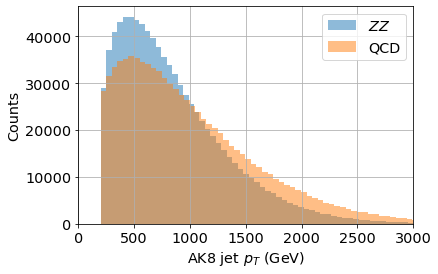

In [31]:
signal['pT'].hist(bins=100, alpha=0.5, label =  signame)
bkg['pT'].hist(bins=100, alpha=0.5, label = bkgname)
plt.xlabel(r'AK8 jet $p_T$ (GeV)')
plt.ylabel("Counts")
plt.xlim(0,3000)
plt.legend()
plt.savefig('plots/jetpt.png')

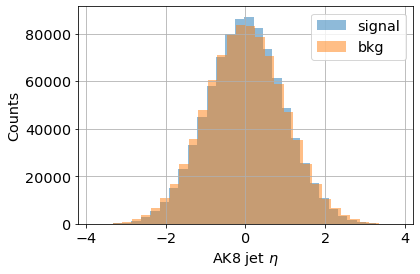

In [32]:
signal['eta'].hist(bins=32, alpha=0.5, label ='signal')
bkg['eta'].hist(bins=32, alpha=0.5, label ='bkg')
plt.xlabel(r'AK8 jet $\eta$')
plt.ylabel("Counts")
plt.legend()
plt.savefig('plots/jeteta.png')

In [ ]:
signal['phi'].hist(bins=25, alpha=0.5, label = signame)
bkg['phi'].hist(bins=25, alpha=0.5, label = bkgname)
plt.xlabel(r'AK8 jet $\phi$ (radians)')
plt.ylabel("Counts")
plt.legend()
plt.savefig('plots/jetphi.png')

In [ ]:
signal['tau21'].hist(bins=100, alpha=0.5, label = signame)
bkg['tau21'].hist(bins=100, alpha=0.5, label =bkgname)
plt.xlabel(r'AK8 jet $\tau_2 / \tau_1$')
plt.ylabel("Counts")
plt.legend()
plt.savefig('plots/jettau21.png')

In [ ]:
signal['n_ch'].hist(bins=np.linspace(0,50,50), alpha=0.5, label = signame)
bkg['n_ch'].hist(bins=np.linspace(0,50,50), alpha=0.5, label =bkgname)
plt.xlim(0,50)
plt.xlabel('Charged Hadron Multiplicity')
plt.ylabel("Counts")
plt.legend()
plt.savefig('plots/n_ch.png')

In [ ]:
signal['n_gamma'].hist(bins=np.linspace(0,100,100), alpha=0.5, label = signame)
bkg['n_gamma'].hist(bins=np.linspace(0,100,100), alpha=0.5, label =bkgname)
plt.xlim(0,60)
plt.xlabel('Photon Multiplicity')
plt.ylabel("Counts")
plt.legend()
plt.savefig('plots/n_gamma.png')

In [ ]:
signal['n_mu'].hist(bins=np.linspace(0,100,100), alpha=0.5, label = signame)
bkg['n_mu'].hist(bins=np.linspace(0,100,100), alpha=0.5, label =bkgname)
plt.xlim(0,5)
plt.xlabel('Muon Multiplicity')
plt.ylabel("Counts")
plt.legend()
plt.savefig('plots/n_mu.png')

In [ ]:
signal['n_e'].hist(bins=np.linspace(0,100,100), alpha=0.5, label = signame)
bkg['n_e'].hist(bins=np.linspace(0,100,100), alpha=0.5, label =bkgname)
plt.xlim(0,5)
plt.xlabel('Electron Multiplicity')
plt.ylabel("Counts")
plt.legend()
plt.savefig('plots/n_e.png')

In [ ]:
signal['n_nh'].hist(bins=np.linspace(0,50,50), alpha=0.5, label = signame)
bkg['n_nh'].hist(bins=np.linspace(0,50,50), alpha=0.5, label =bkgname)
plt.xlim(0,10)
plt.xlabel('Neutral Hadron Multiplicity')
plt.ylabel("Counts")
plt.legend()
plt.savefig('plots/n_nh.png')

In [ ]:
train_data = shuffle(signal.iloc[:int(numData*0.8)].append(bkg.iloc[:int(numData*0.8)])).reset_index(drop=True)
test_data = shuffle(signal.iloc[int(numData*0.8):].append(bkg.iloc[int(numData*0.8):])).reset_index(drop=True)

# Image Only CNN

In [ ]:
def build_model():
    input1 = layers.Input(shape = (16, 16,1))
    x = layers.Conv2D(32, (8, 8), activation='relu',padding='same', name = 'conv1')(input1)
    x = layers.Conv2D(32, (4, 4), activation='relu',padding='same', name = 'conv2')(x)
    x = layers.Conv2D(32, (2, 2), activation='relu',padding='same', name = 'conv3')(x)
#     x = layers.MaxPool2D((4, 4), name = 'maxpool4x4')(x)
#     x = layers.Conv2D(32, (6, 6), activation='relu',padding='same', name = 'conv4')(x)
#     x = layers.Conv2D(32, (4, 4), activation='relu',padding='same', name = 'conv5')(x)
    x = layers.MaxPool2D((2, 2), name = 'maxpool2x2')(x)
    x = layers.Flatten(name = 'flatten')(x)
    x = layers.Dense(256, activation='relu', name = 'relu')(x)
    output = layers.Dense(2, activation='softmax', name = 'softmax')(x)
    model = models.Model(inputs=input1, outputs=output)
    
    opt=keras.optimizers.Adam(lr=0.001,beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=['binary_crossentropy', 'accuracy'])
    return model

In [ ]:
ImageonlyCNN = build_model()
# ImageonlyCNN.summary()

In [ ]:
X_batch = np.array(list(train_data['image'][:10].values))
Y_batch = np.array(list(train_data['labels'][:10].values))
example_result = ImageonlyCNN.predict(x = X_batch)
results = ImageonlyCNN.evaluate(x = X_batch, y =Y_batch )
print(example_result)
print(results)

In [ ]:
checkpoint_path = "model/CNN_imageonly_full_final.h1"
if not os.path.exists("model"):
    os.mkdir("model")

model_checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', 
                                   verbose=1, save_best_only=True, 
                                   save_weights_only=False, mode='auto',
                                   period=1)  #save_freq='epoch',   
EPOCHS = 3
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
history = ImageonlyCNN.fit(
  np.array(list(train_data['image'].values)), np.array(list(train_data['labels'].values)),
  epochs=EPOCHS, validation_split = 0.2, verbose = 1,
  callbacks=[early_stop, model_checkpoint])
ImageonlyCNN.save(checkpoint_path)

In [ ]:
!ls model
best_model = tf.keras.models.load_model('model/CNN_imageonly_full_final.h1', custom_objects=None, compile=True)
best_model.summary()
results = best_model.evaluate(np.array(list(test_data['image'].to_dict().values())), np.array(list(test_data['labels'].to_dict().values())))
results

In [ ]:
predict = best_model.predict(np.array(list(test_data['image'].to_dict().values())))

In [ ]:
plt.rcParams['figure.dpi'] = 70

In [ ]:
# Plot ROC
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(np.array(list(test_data['labels'].to_dict().values()))[:,1], predict[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='b', label='auc = %.3f' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Receiver Operating Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# plt.hist([predict[np.argwhere(np.array(list(test_data['labels'].to_dict().values()))[:, 1] == 1), 0].flatten(), predict[np.argwhere(np.array(list(test_data['labels'].to_dict().values()))[:, 0] == 1), 0].flatten()]
#          , histtype = 'step', label = ['QCD', 'ZZ'])
# plt.xlabel('Prediction')
# plt.yscale('log')
# plt.legend(loc="lower center")
# plt.show()

# CNN for Image+Variables

In [ ]:
# the second input will be -> train_data[np.array(train_data.keys()[1:-1], dtype='str')].values

In [ ]:
def build_model_injected():
    input2 = layers.Input(shape=(10,))
    input1 = layers.Input(shape = (16, 16,1))
    x = layers.Conv2D(32, (8, 8), activation='relu',padding='same', name = 'conv1')(input1)
    x = layers.Conv2D(32, (4, 4), activation='relu',padding='same', name = 'conv2')(x)
    x = layers.Conv2D(32, (2, 2), activation='relu',padding='same', name = 'conv3')(x)
    x = layers.MaxPool2D((2, 2), name='maxpool2x2')(x)
    x1 = layers.Flatten(name = 'flatten')(x)
    x = layers.concatenate(inputs=([x1,input2]), axis=-1, name='concat')
    x = layers.Dense(256, activation='relu', name='relu')(x)
    output = layers.Dense(2, activation='softmax', name='softmax')(x)
    model = models.Model(inputs=(input1,input2), outputs=output)
    
    opt=keras.optimizers.Adam(lr=0.001,beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=['binary_crossentropy', 'accuracy'])
    return model

In [ ]:
InjectedVarsCNN = build_model_injected()

In [ ]:
var = train_data[np.array(train_data.keys()[1:-1], dtype='str')].values

In [ ]:
X_batch = [np.array(list(train_data['image'].values))[:10], var[:10]]
Y_batch = np.array(list(train_data['labels'].values))[:10]
example_result = InjectedVarsCNN.predict(x = X_batch)
results = InjectedVarsCNN.evaluate(x = X_batch, y = Y_batch )
print(example_result)
print(results)

In [ ]:
checkpoint_path = "model/CNN_allVars_full_final.h1"
if not os.path.exists("model"):
    os.mkdir("model")

model_checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', 
                                   verbose=1, save_best_only=True, 
                                   save_weights_only=False, mode='auto',
                                   period=1) #save_freq='epoch'   
EPOCHS = 4
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
history = InjectedVarsCNN.fit(
  [np.array(list(train_data['image'].values)), var], np.array(list(train_data['labels'].values)),
  epochs=EPOCHS, validation_split = 0.2, verbose = 1,
  callbacks=[early_stop, model_checkpoint])

InjectedVarsCNN.save(checkpoint_path)

In [ ]:
test_var = test_data[np.array(test_data.keys()[1:-1], dtype='str')].values
# test_var = test_var.reshape(test_var.shape[0], test_var.shape[1], 1)
# test_var.shape

In [ ]:
!ls model
best_model_allVars = tf.keras.models.load_model('model/CNN_allVars_full_final.h1', custom_objects=None, compile=True)
best_model_allVars.summary()
results_allVars = best_model_allVars.evaluate([np.array(list(test_data['image'].values)), test_var], np.array(list(test_data['labels'].values)))
results_allVars

In [ ]:
predict = best_model_allVars.predict([np.array(list(test_data['image'].values)), test_var])

In [ ]:
# Plot ROC
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(np.array(list(test_data['labels'].values))[:,1], predict[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='b', label='auc = %.3f' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Receiver Operating Curve')
plt.legend(loc="lower right")
plt.show()
# plt.savefig('plots/roc_image_allVars.png')